In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits'],
      dtype='<U66')

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits
[92.17609]


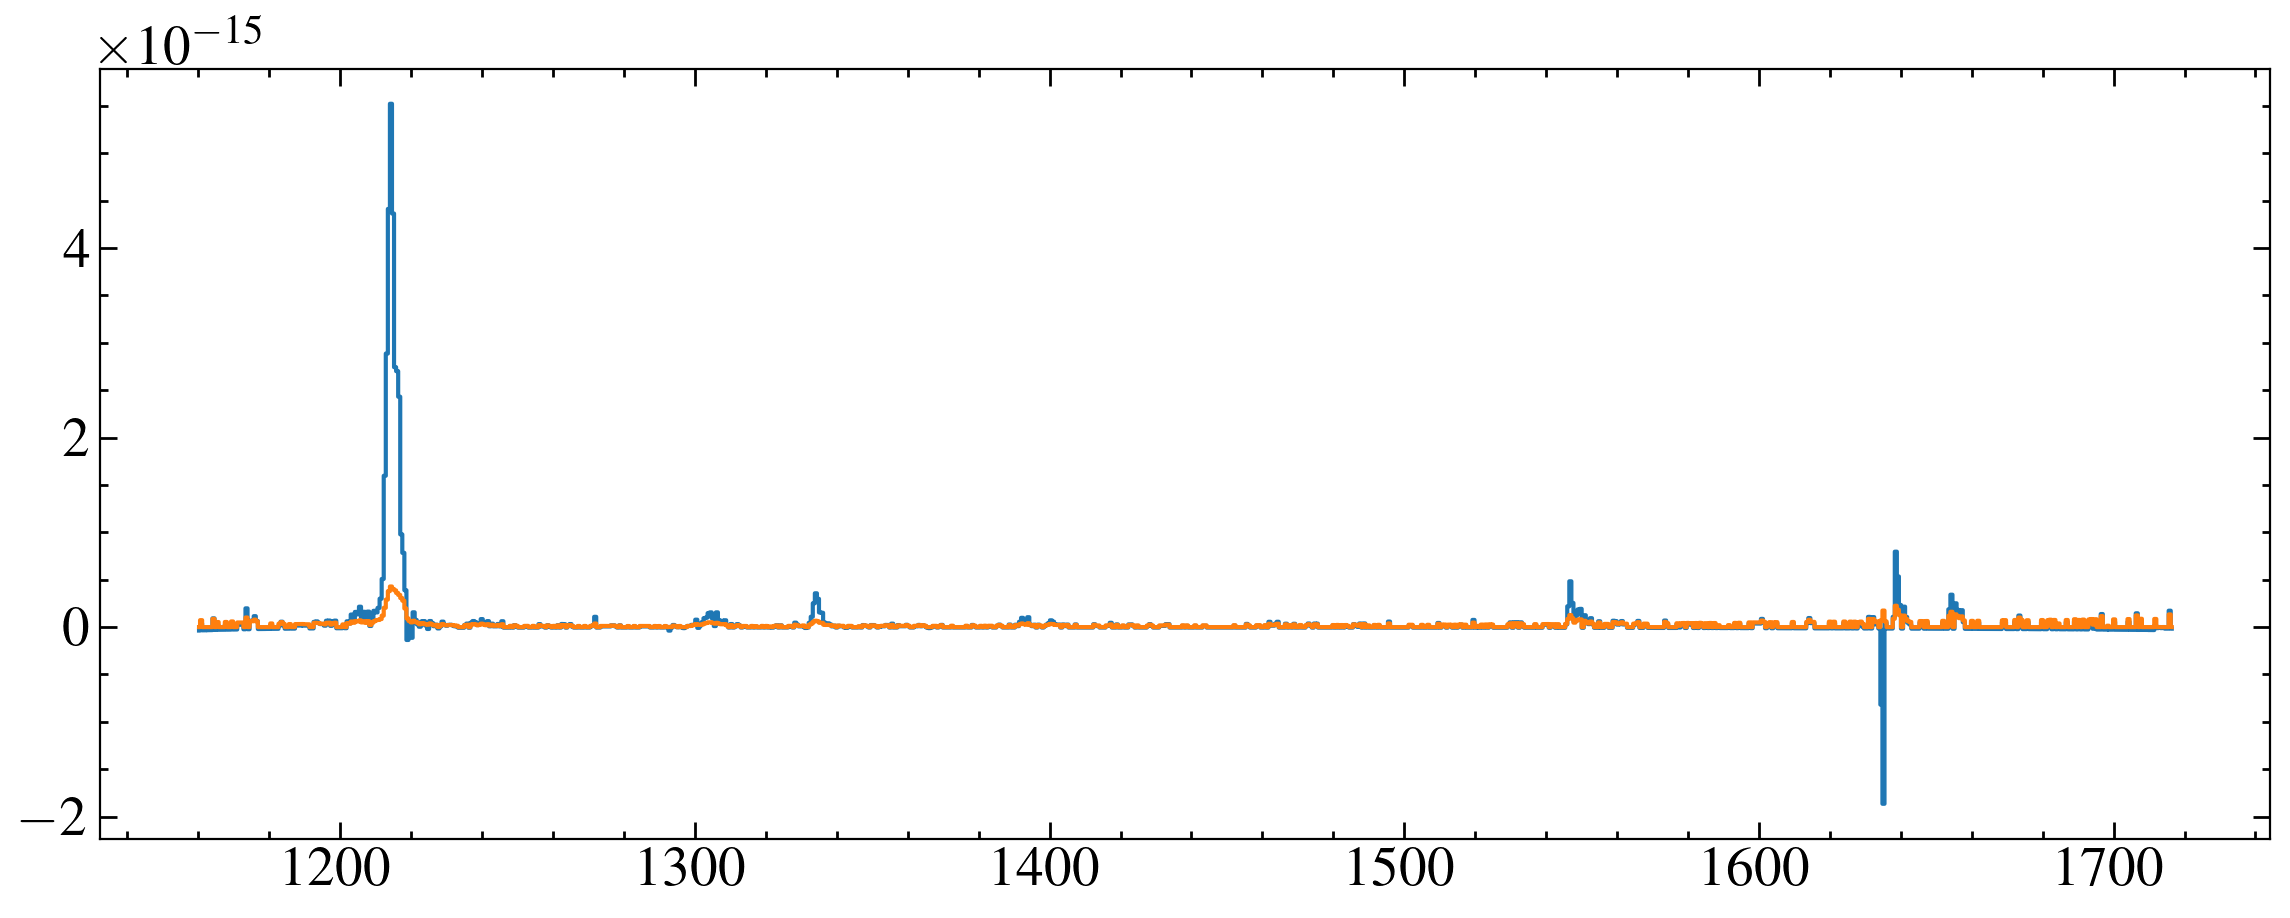

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits
[498.31918]


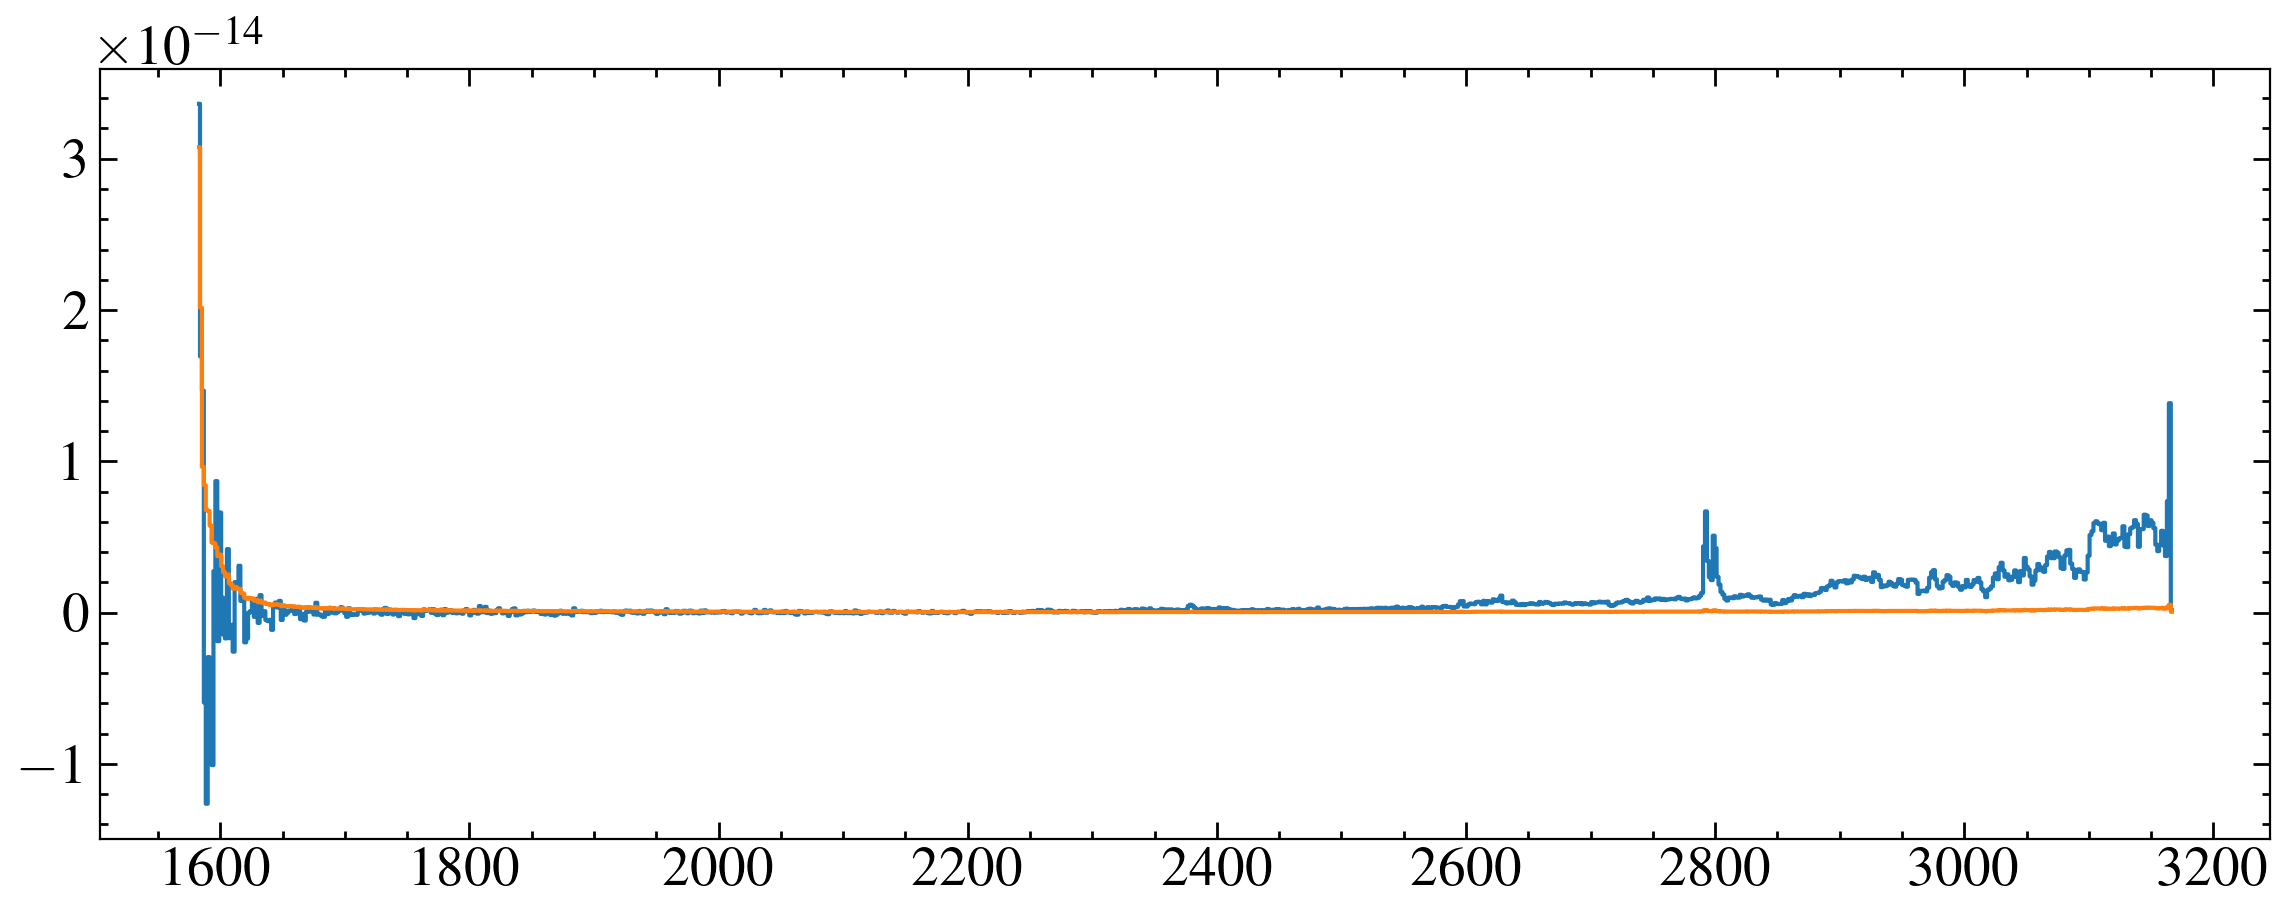

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits
[130.67415]


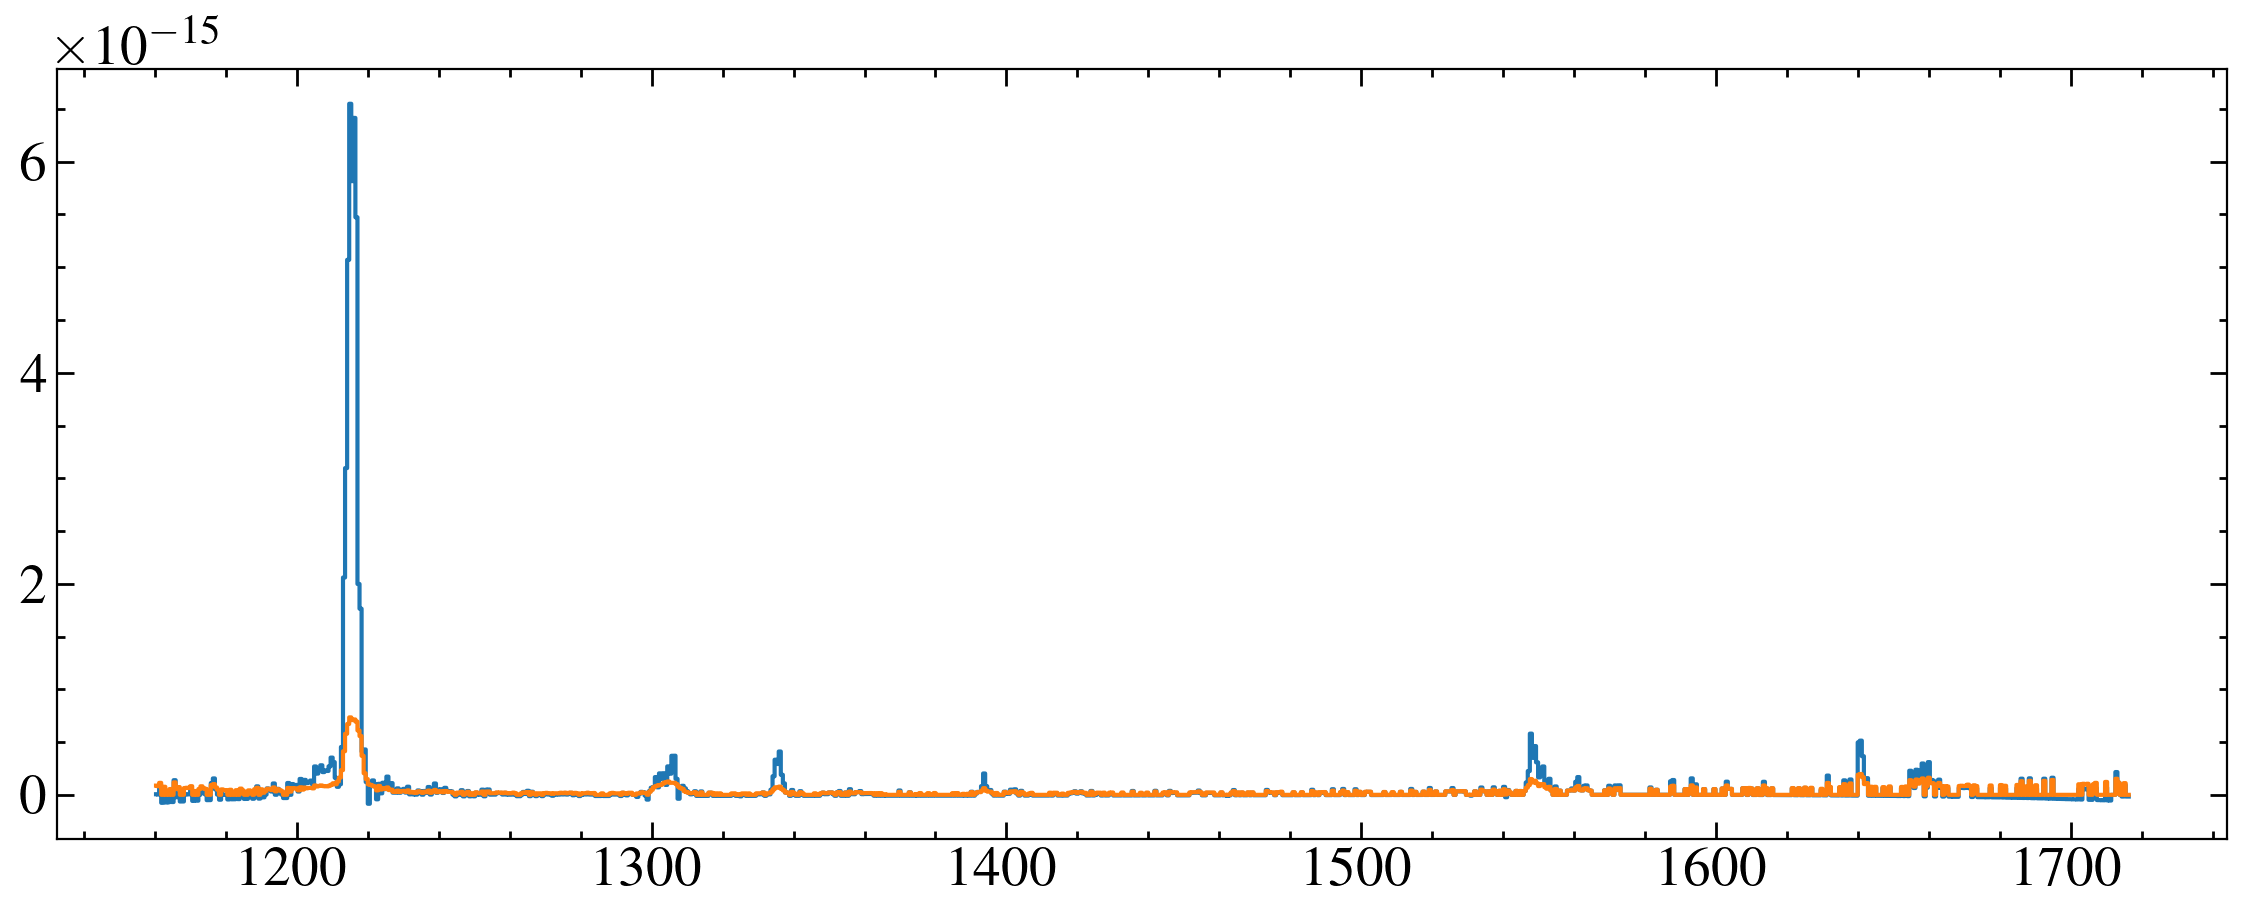

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits
[895.0867]


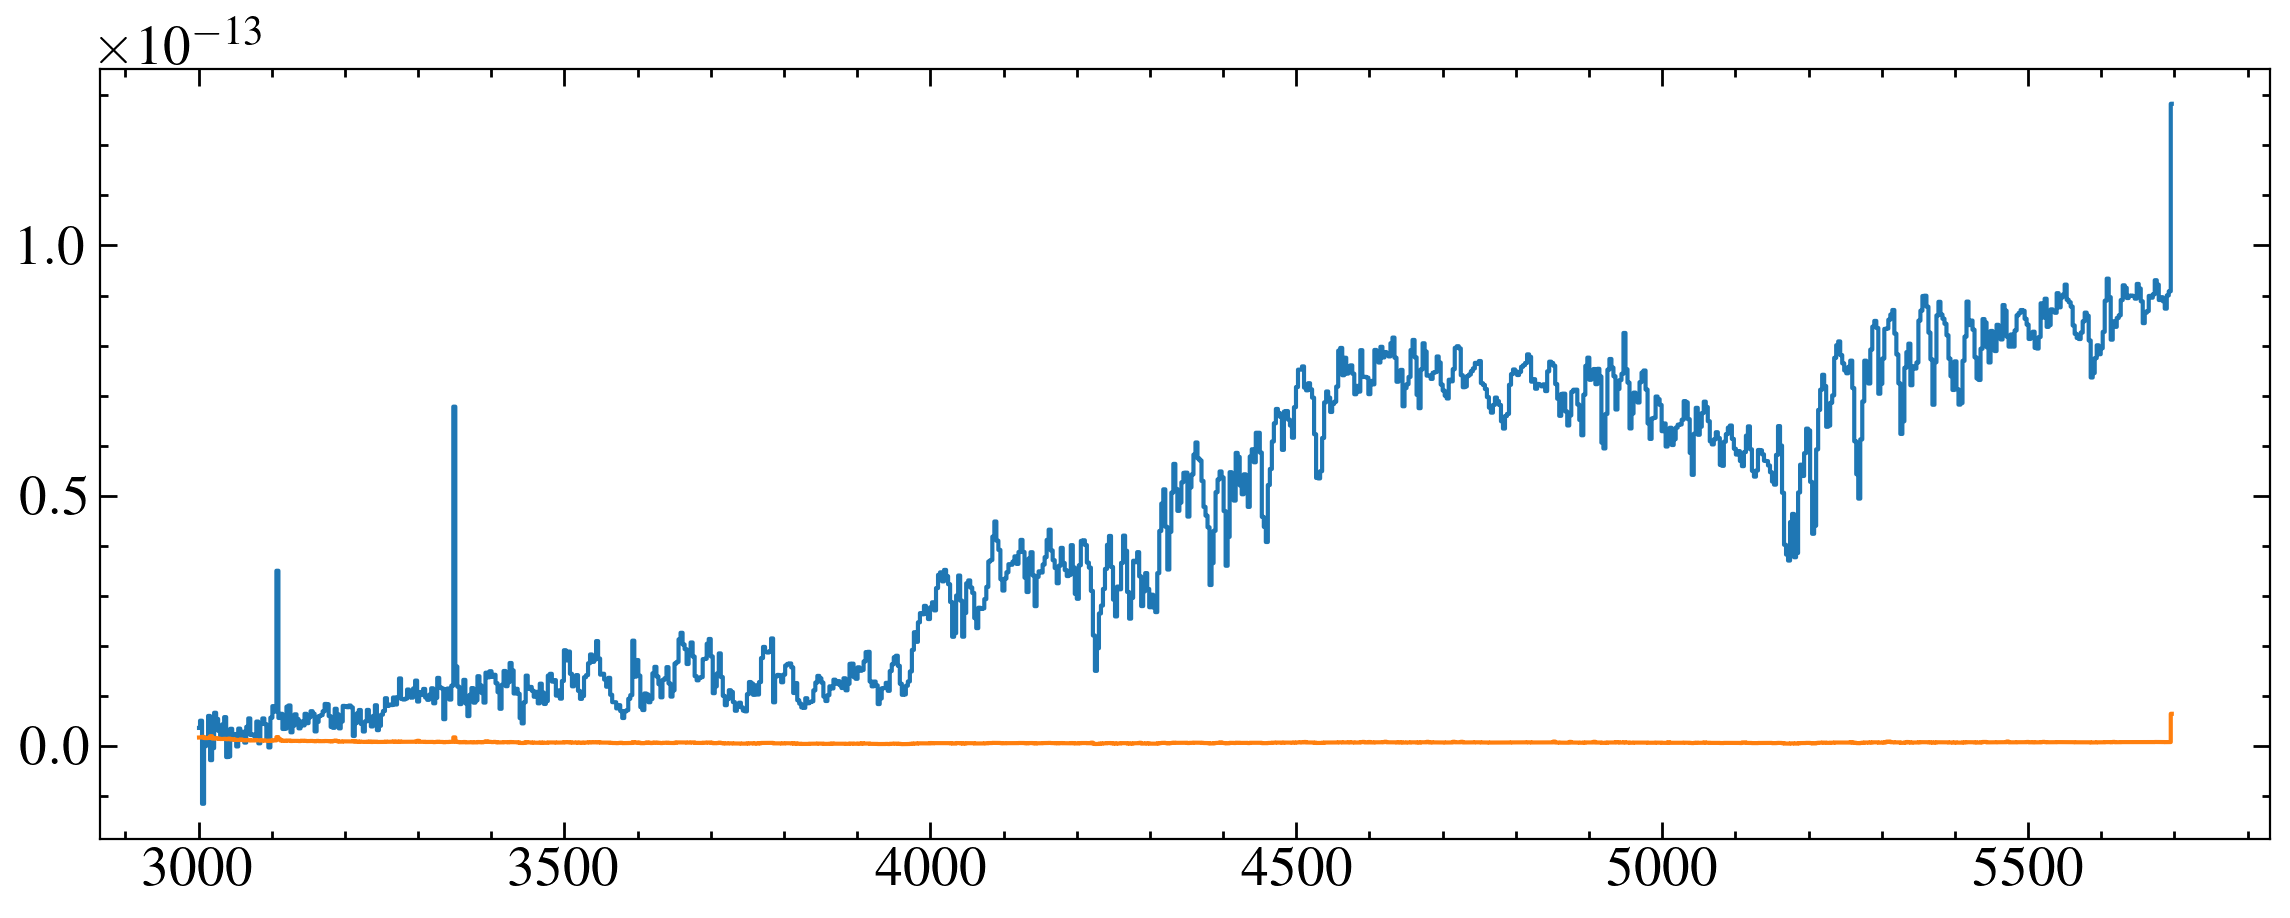

In [3]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    for dt in data:
        w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
        if grating == 'G430L':
            mask = w > 3000
        else:
            mask = w > 1160
        
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid', c='C0')
        plt.step(w, e, where='mid', c='C1')
        # plt.yscale('log')
    plt.show()

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-17)

/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


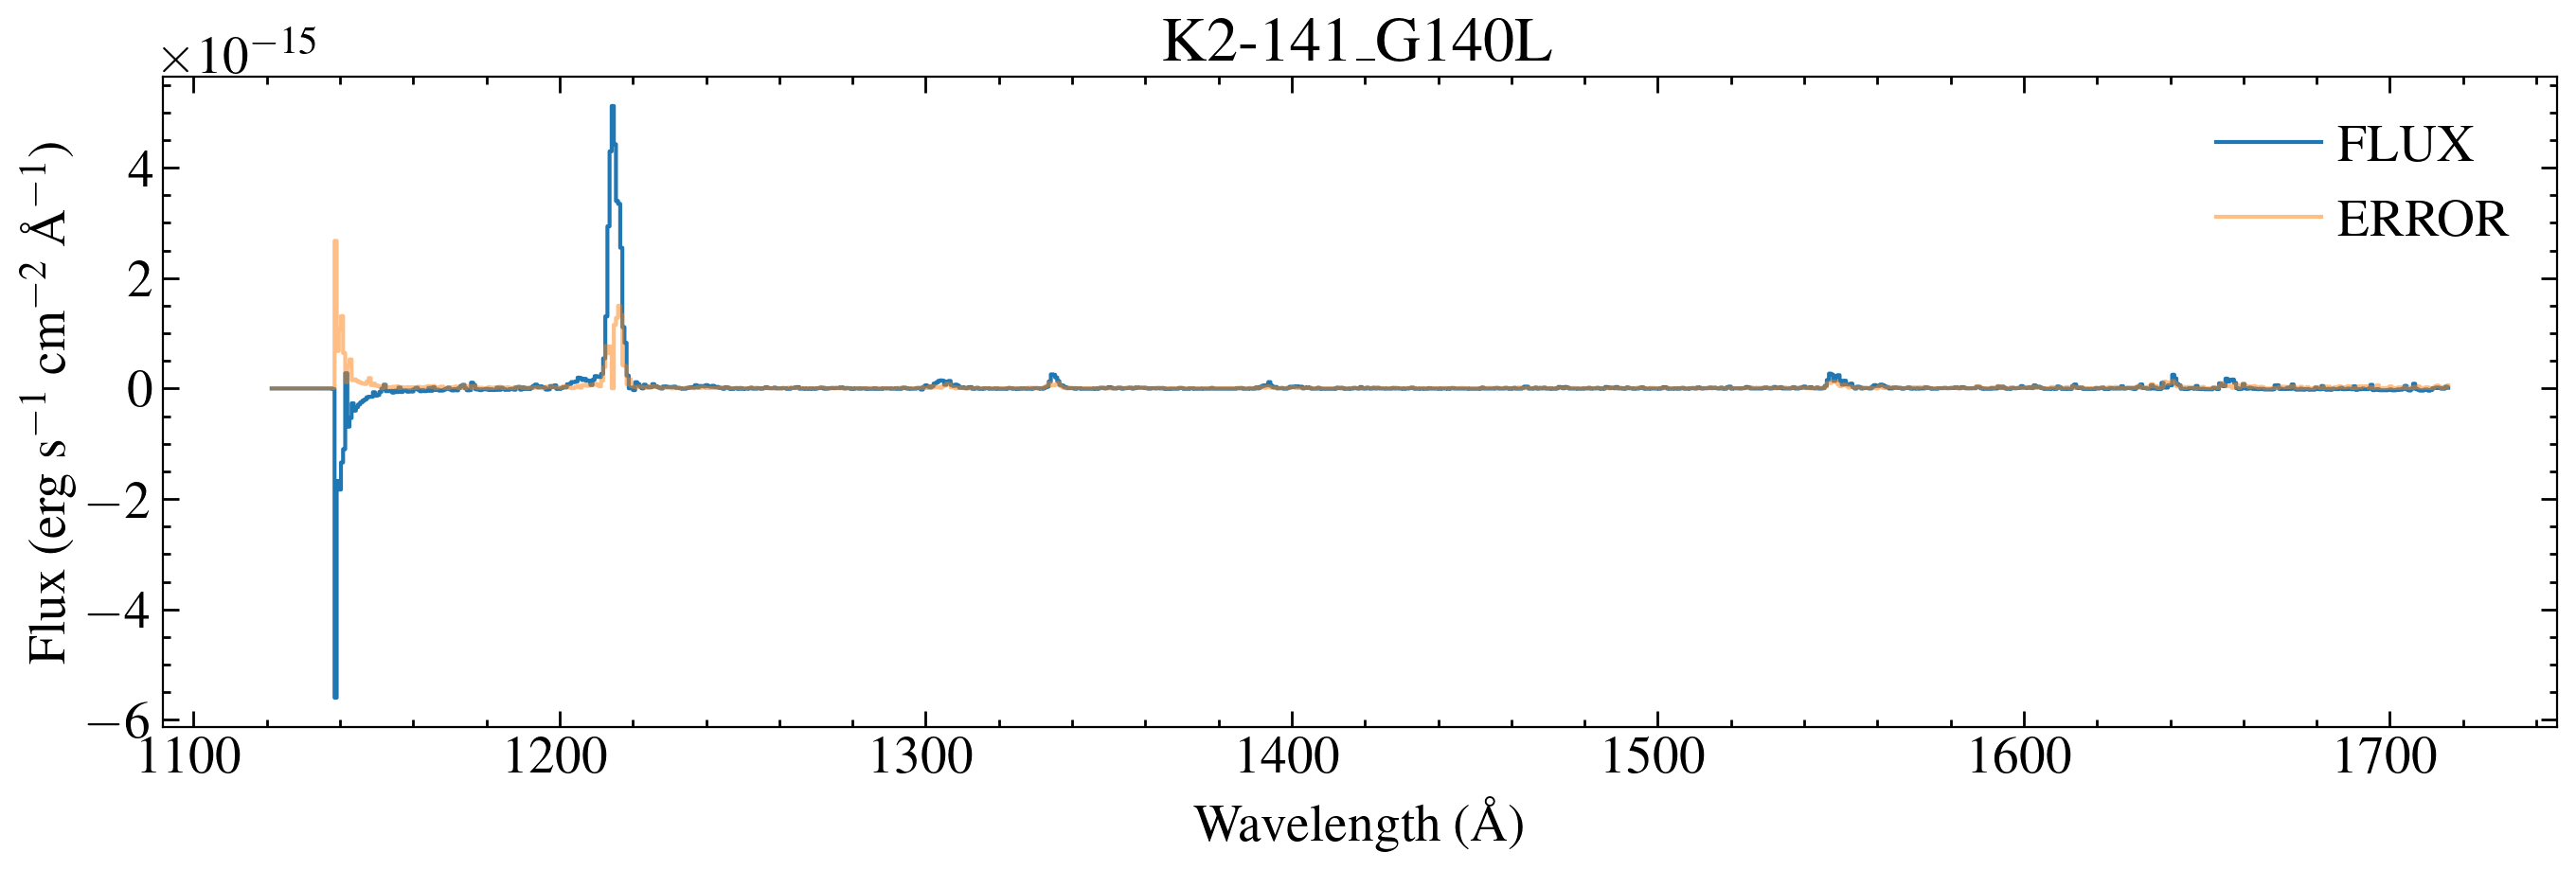

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g140l_v1_component-spec.fits


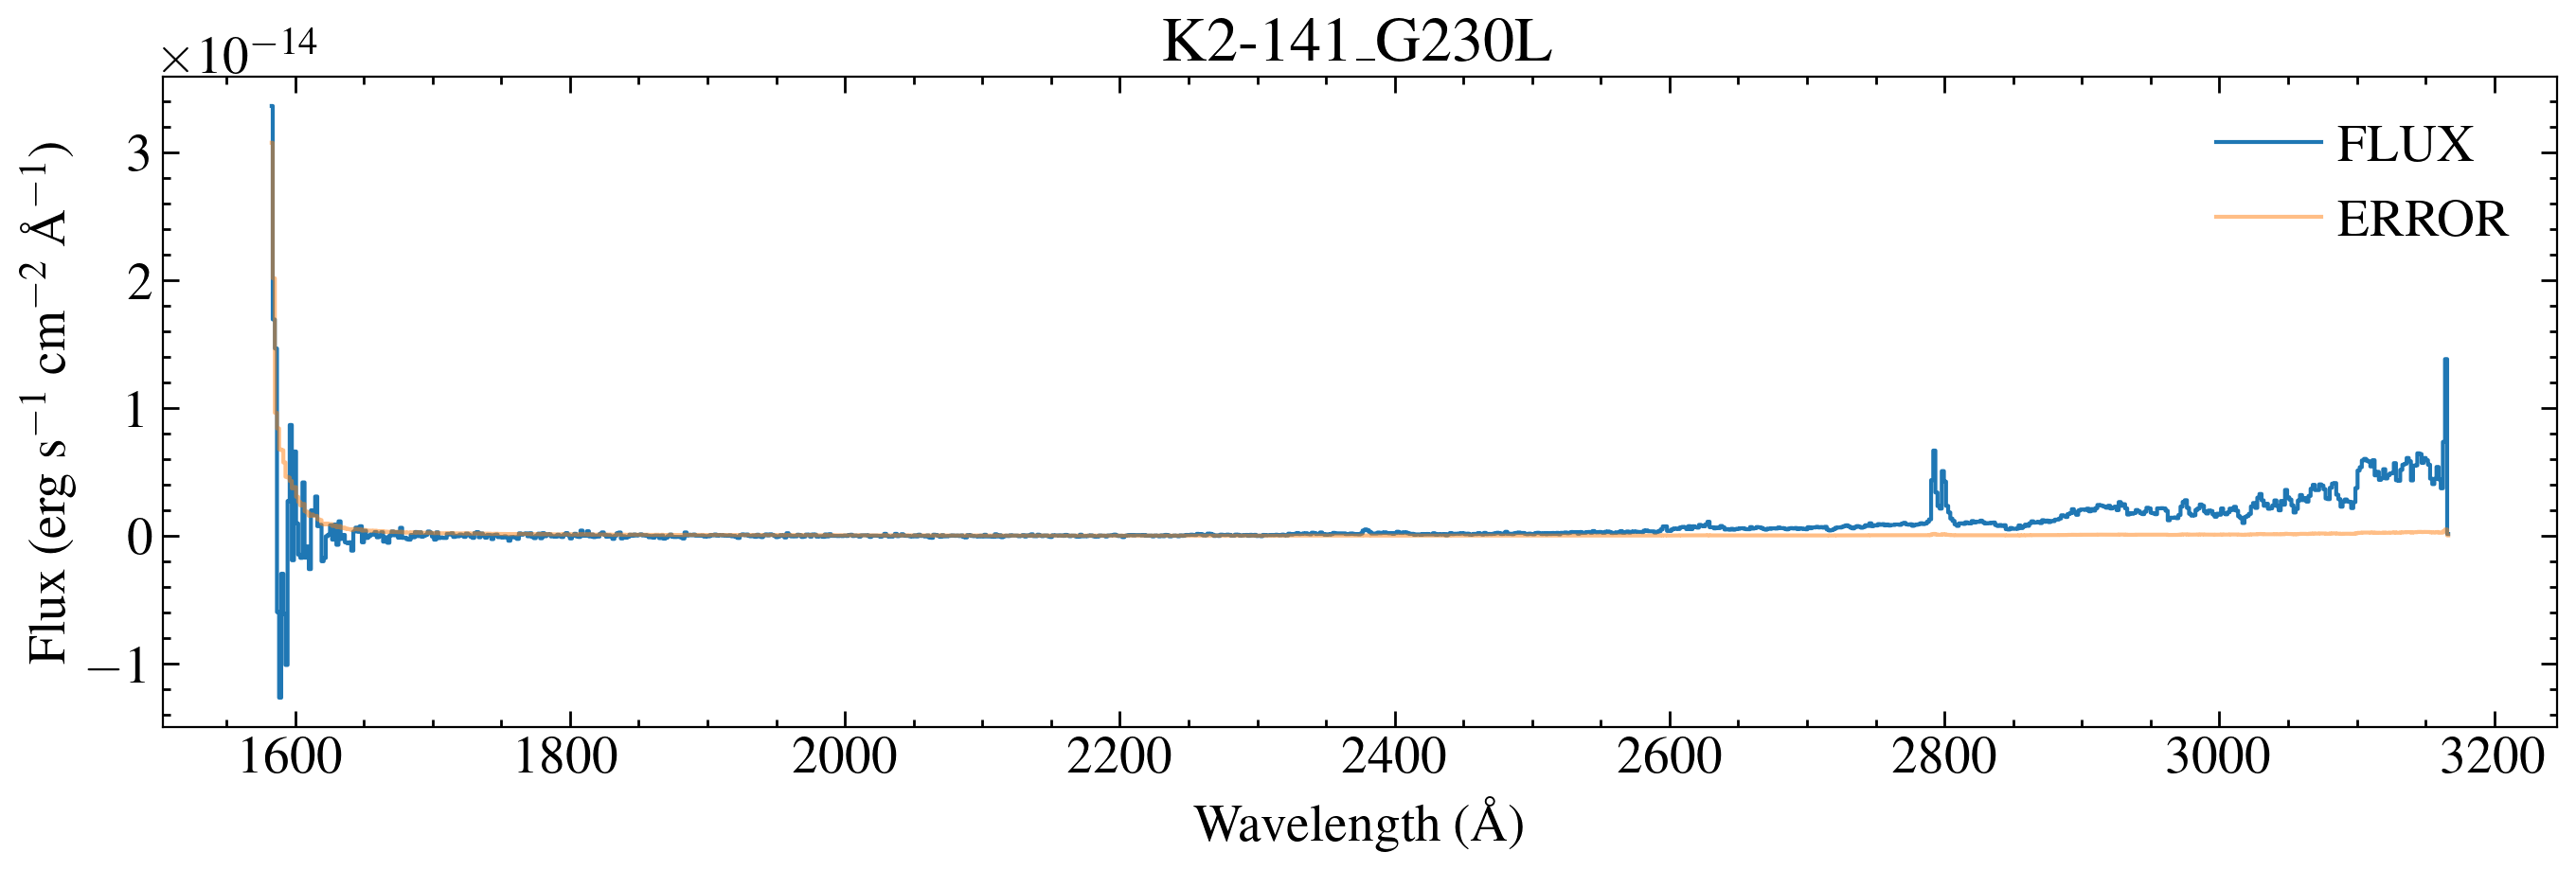

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits


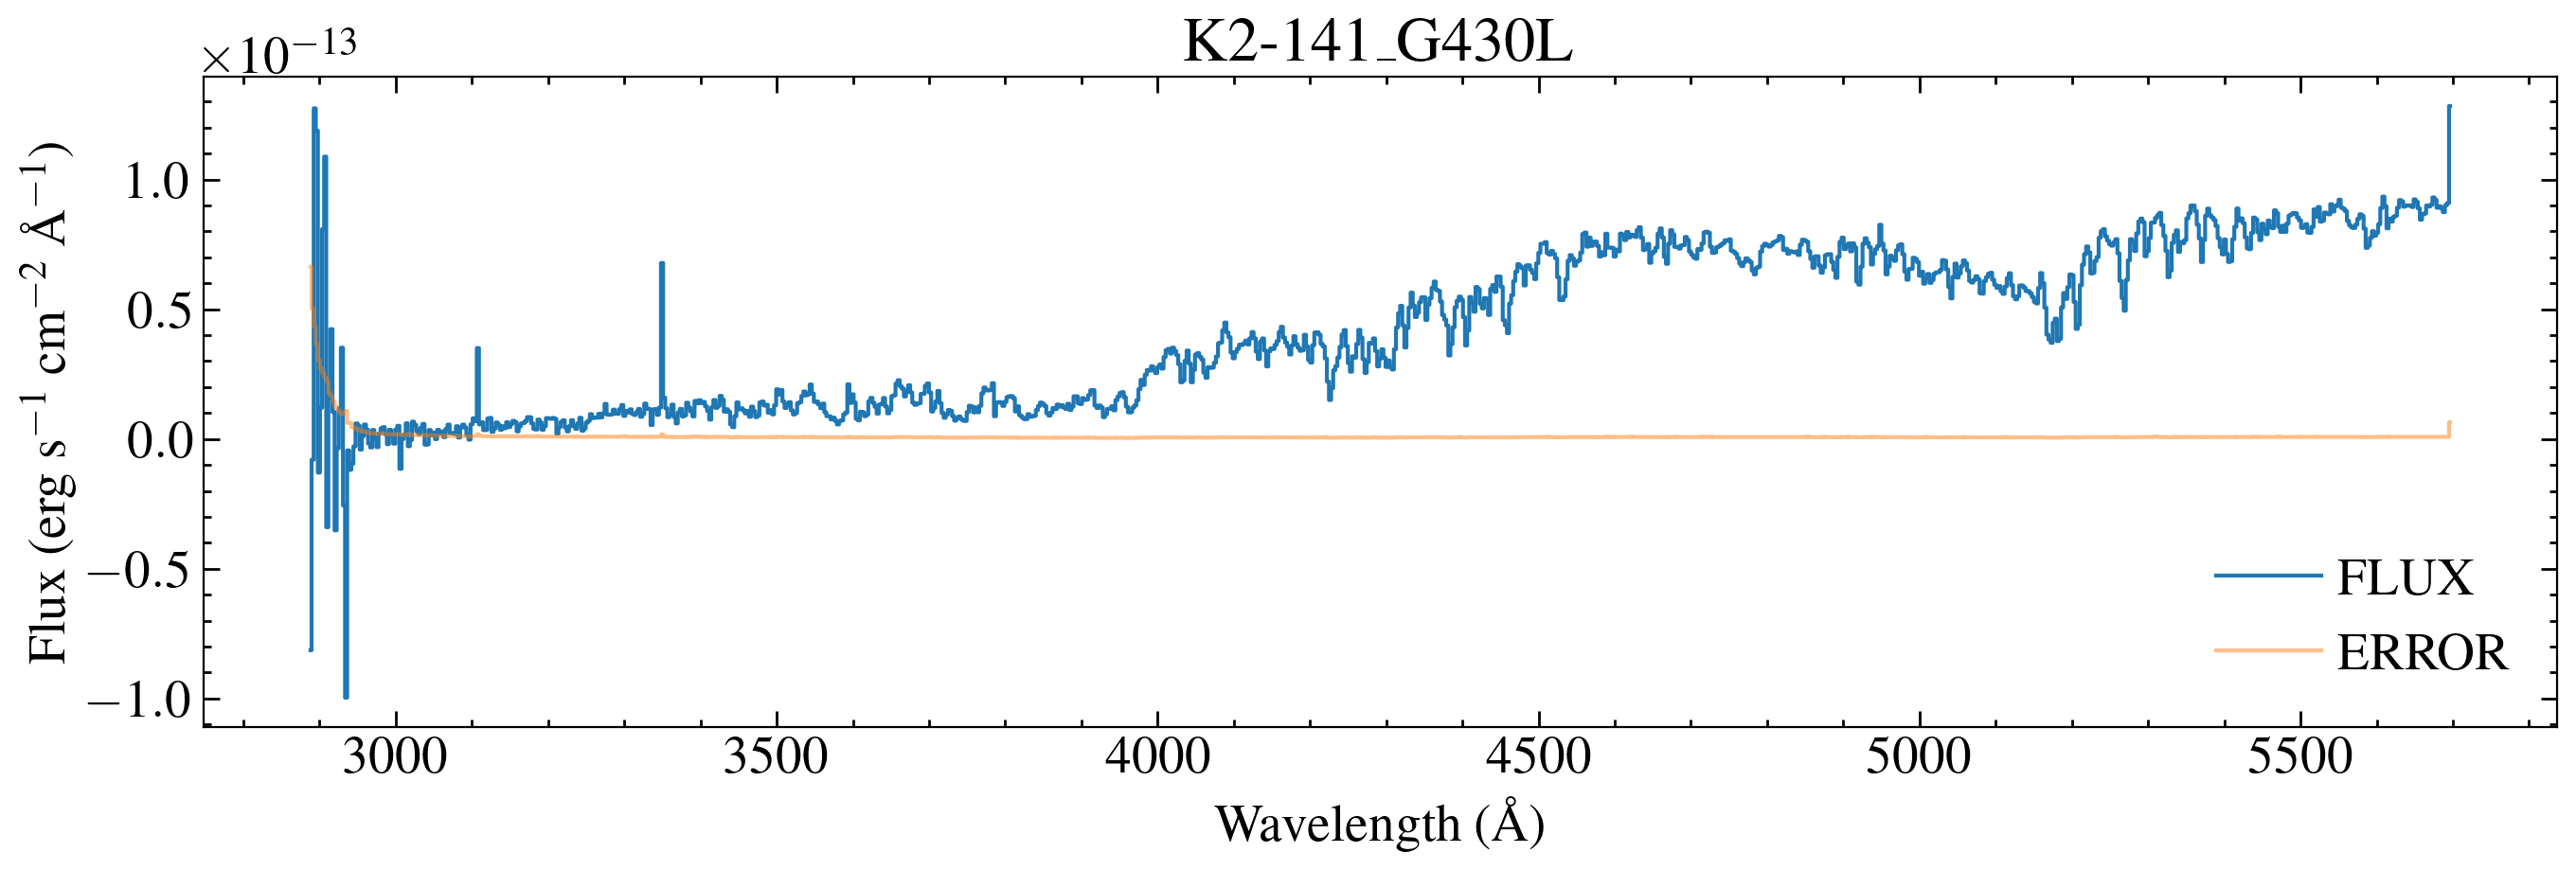

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits


In [4]:
import prepare_stis
x1dpath = path
savepath = 'draft_hlsp/k2-141/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'K2-141')

In [5]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.708
teff = 4599
teff_e = 79

radius = 0.681
distance = 62.00

save_path = 'models/'
star = 'k2-141'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.62
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [6]:
hlsp_stis = glob.glob('draft_hlsp/k2-141/*stis*.fits')
hlsp_stis

['draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits',
 'draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g140l_v1_component-spec.fits',
 'draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits']

In [7]:
from dust_extinction.parameter_averages import F99


In [8]:
# swift
swiftpath = '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/'
uvots = glob.glob('{}*phot.fits'.format(swiftpath))
uvots

['/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_b_phot.fits',
 '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_uvm2_phot.fits',
 '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_u_phot.fits',
 '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_v_phot.fits']

0.04516129032258065


KeyError: 'V'

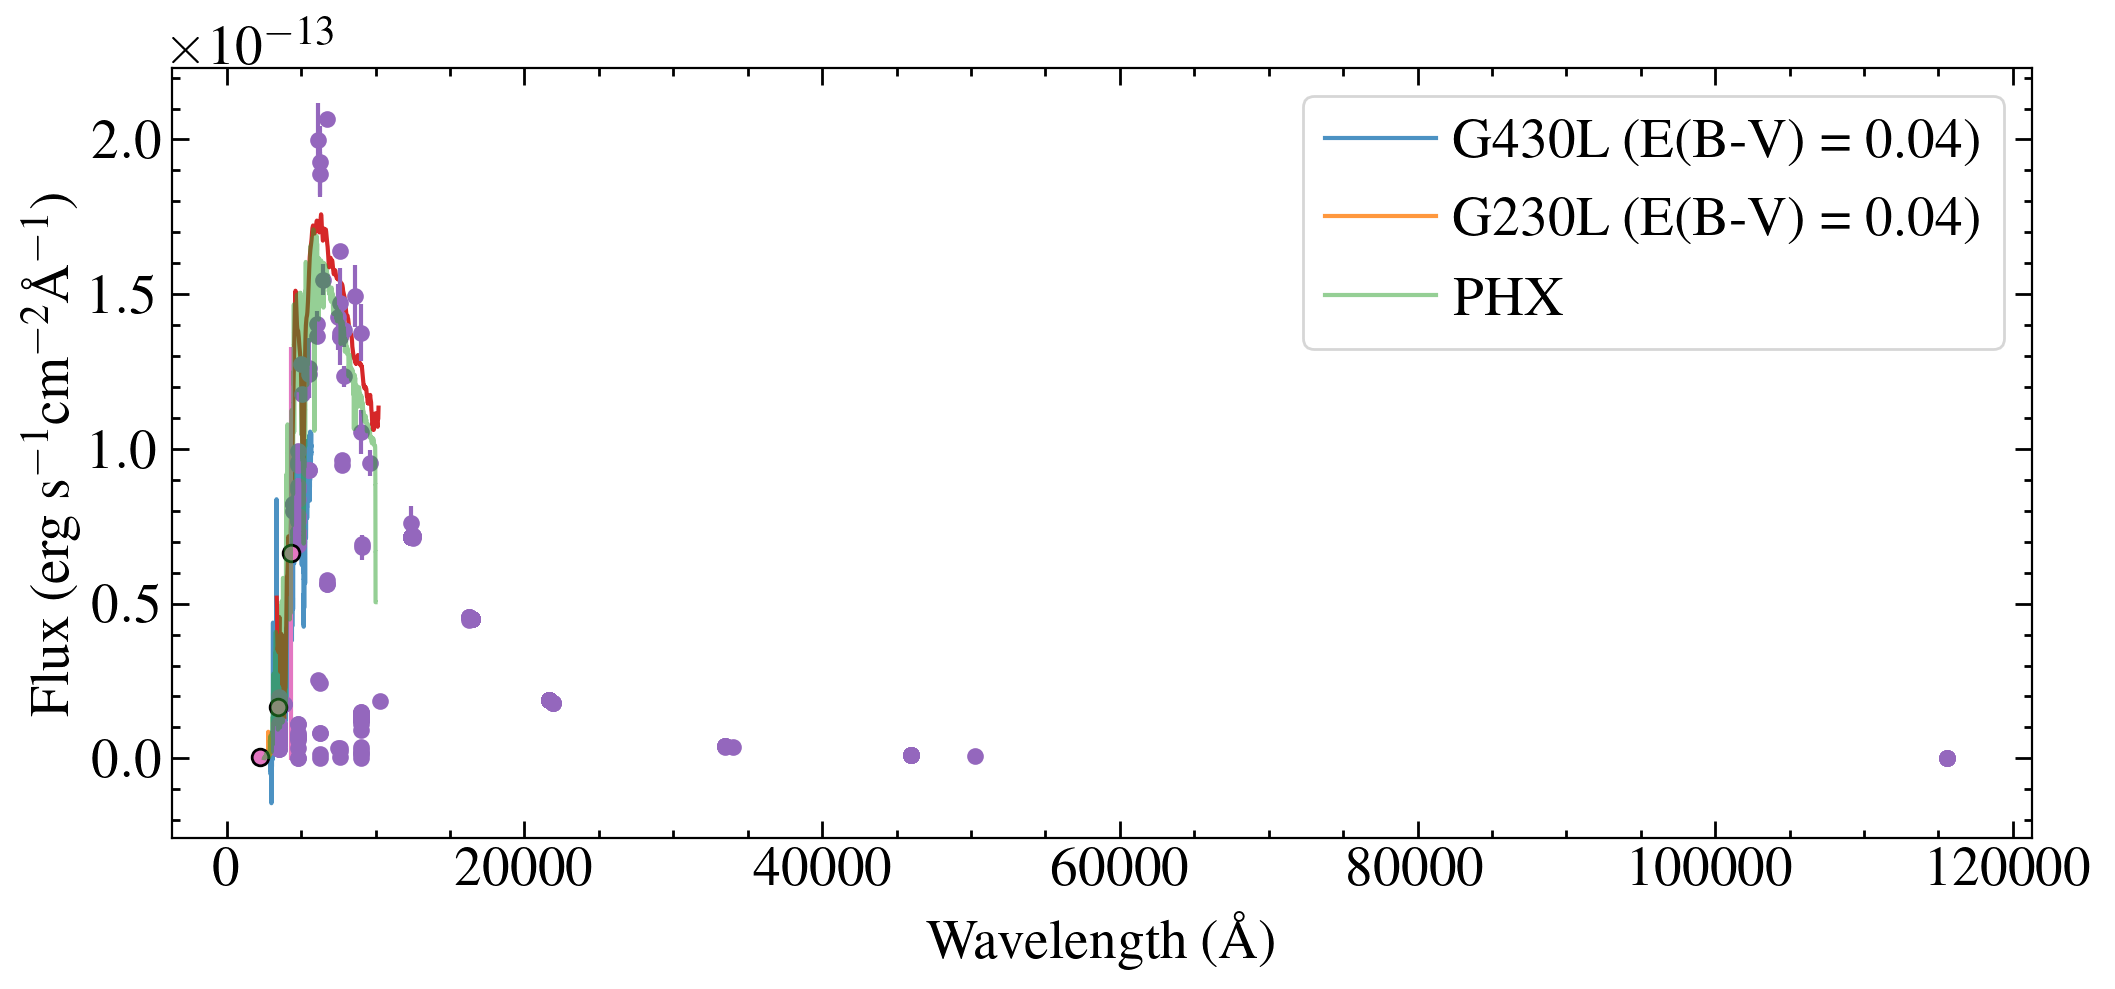

In [9]:
pmask = (pw > 2500) & (pw < 10000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


fig, ax = plt.subplots(figsize=(12,5))


ext = F99(Rv=3.1)
ebv = 0.14/3.1
print(ebv)


# for spec in hlsp_stis:
spec = hlsp_stis[0]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 2950) & (w < 5690 )    
w, f, e = w[mask], f[mask], e[mask]

red = ext.extinguish(w*u.AA, Ebv = ebv)

# ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
ax.step(w, f/red, where='mid', label = 'G430L (E(B-V) = 0.04)',  alpha=0.8)



spec = hlsp_stis[2]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 2000) & (w < 3000 )    
w, f, e = w[mask], f[mask], e[mask]

red = ext.extinguish(w*u.AA, Ebv = ebv)

# ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
ax.step(w, f/red, where='mid', label = 'G230L (E(B-V) = 0.04)',  alpha=0.8)

  
ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5, label = 'PHX')

ax.legend(frameon=True)

ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')


gaia = Table.read('misc_data/k2-141_gaia.vot')
mask = gaia['type'] == 'XP'
gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
# mask = (gw > 3000) #& (gw < 1000)
# gw, gf = gw[mask], gf[mask]

gaia_red = ext.extinguish(gw*u.AA, Ebv = ebv)
ax.plot(gw, gf/gaia_red, label='Gaia XP (E(B-V) = 0.04)')

# ax.plot(gw, gf, label='Gaia XP')
phot = Table.read('misc_data/k2-141_phot.vot')



mask = (~phot['sed_eflux'].mask) & (phot['sed_eflux'] > 0) 



phot_w = (phot['sed_freq'][mask]).to(u.AA,  equivalencies=u.spectral())
phot_f = (phot['sed_flux'][mask]).to(u.erg/u.s/u.cm**2/u.AA,  equivalencies=u.spectral_density(phot_w))
phot_e =np.array(phot['sed_eflux'][mask])
phot_e = ((phot_e/phot['sed_flux'][mask]).value)*phot_f.value

mask = phot_f.value/phot_e > 10
# print(phot_e)
# print(phot_e)
ax.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5)


swift_ws = dict(U=3467.05, UVM2=2246.43, B=4349.56)

for uvot in uvots:
    data = fits.getdata(uvot, 1)[0]
    band = data['FILTER']
    ax.errorbar(swift_ws[band], data['FLUX_AA'], data['FLUX_AA_ERR'], marker='o', markeredgecolor='k', ls='none', c='C6')

#uves useless
# uves_path = '/media/david/2tb_ext_hd/hddata/meats/misc_data/k2-141/'
# uves_specs = glob.glob('{}*ADP*.fits'.format(uves_path))
# for spec in uves_specs:
#     data = fits.getdata(spec, 1)[0]
#     flux = convolve(data['FLUX'], Box1DKernel(500)) 
#     ax.plot(data['WAVE'], flux*1e-15)



ax.set_xlim(2001, 9999)
ax.set_yscale('log')
ax.set_ylim(1e-16)
fig.tight_layout()




Ugh oh. There were guide star issues in the first observation, are G140ls different?

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits
[92.17609]
/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits
[130.67415]
/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits


(-5e-17, 5e-16)

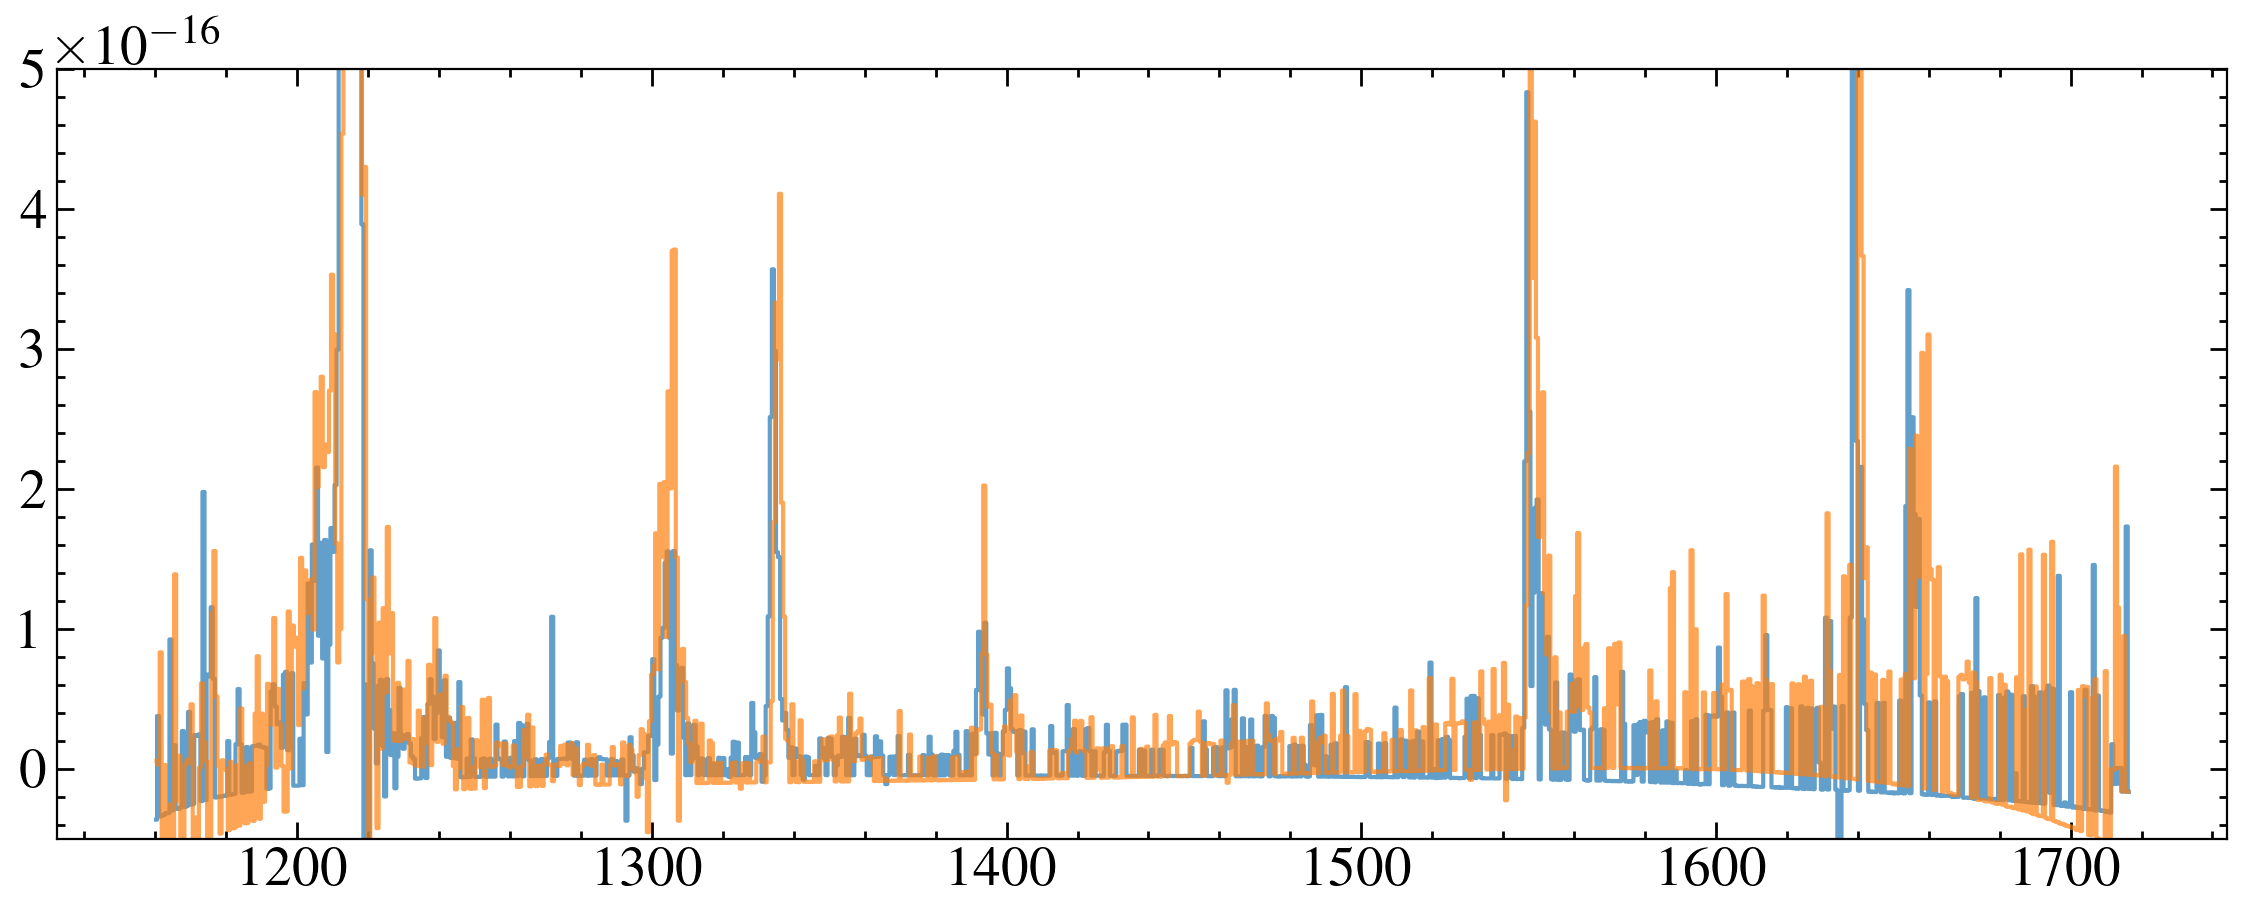

In [10]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
    # print(fits.getheader(x, 0)['OPT_ELEM'])
        data = fits.getdata(x, 1)
        print(data['A2Center'])
        # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        for dt in data:
            w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
            if grating == 'G430L':
                mask = w > 3000
            else:
                mask = w > 1160
            
            w, f, e = w[mask], f[mask], e[mask]
            plt.step(w, f, where='mid', alpha=0.7)
            # plt.step(w, e, where='mid', c='C1')
            # plt.yscale('log')
        # plt.show()
    
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-17)
plt.ylim(-0.5e-16, 0.5e-15)

Already implemented the slitloss corrections,can play!

In [11]:
def slit_loss(wavelength_array, offset, coeff_table_path = 'slit_loss_coeffs.txt'):
    """
    Implements the slit loss correction from https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/stis/documentation/instrument-science-reports/_documents/2022_05.pdf Section 3.2
    """
    coeff_tab = Table.read(coeff_table_path, format='ascii.basic') 
    row = coeff_tab[coeff_tab['Offset(′′)'] == offset]
    # print(row)
    q = (wavelength_array/ 4500)**0.5
    D_lambda = row['a'][0] + row['b'][0]*q + row['c'][0]*q**2 + row['d'][0]*q**3 + row['e'][0]*q**4 + row['f'][0]*q**5 + row['g'][0]*q**6 
    return D_lambda


offtab = Table.read('slit_loss_coeffs.txt', format='ascii.basic')
# offtab

print(offtab['Offset(′′)'])

Offset(′′)
----------
     -0.06
     -0.05
     -0.04
     -0.03
     -0.02
     -0.01
      0.01
      0.02
      0.03
      0.04
      0.05
      0.06


B 1.1561016366107464
U 1.205202643711725
V 1.3679609948936944
uvm2 1.5994675620983057
gNUV 1.3545715431529834


(1e-16, 1.3559490670638444e-14)

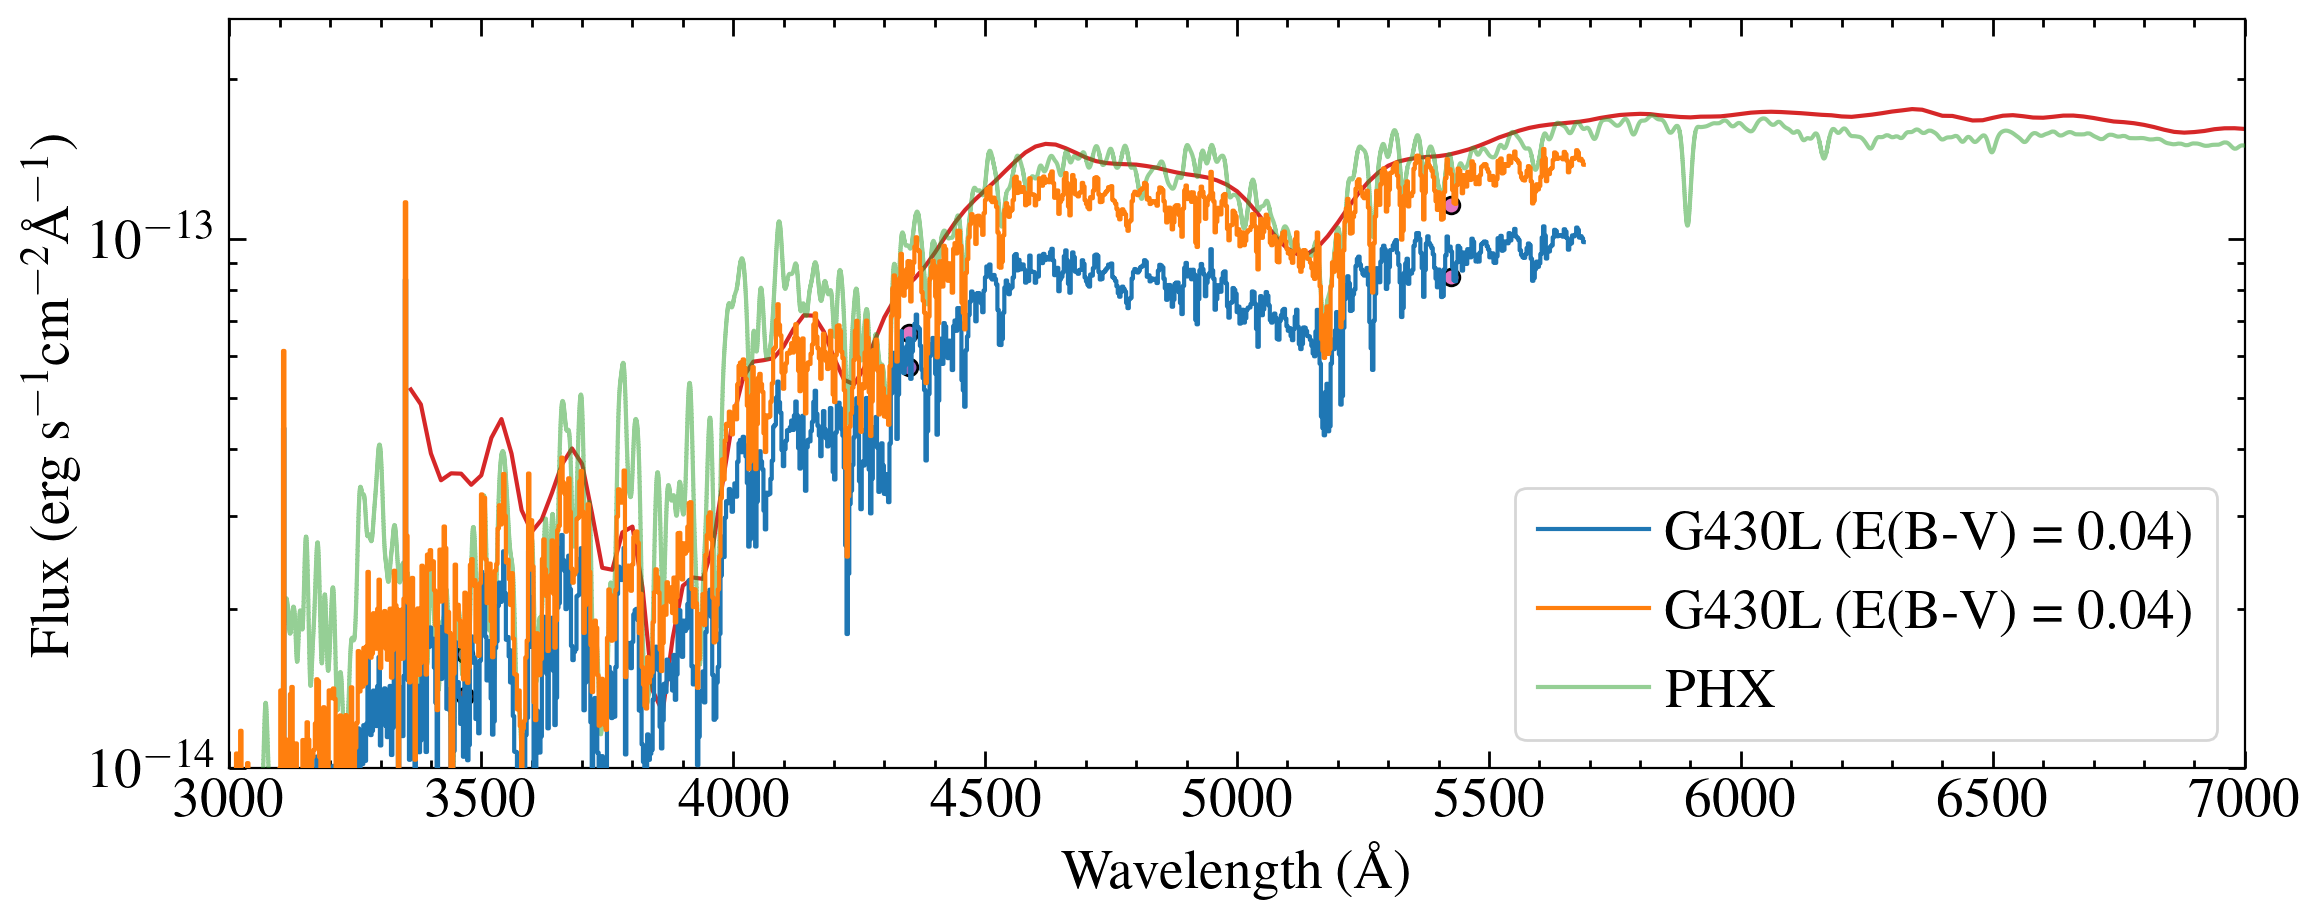

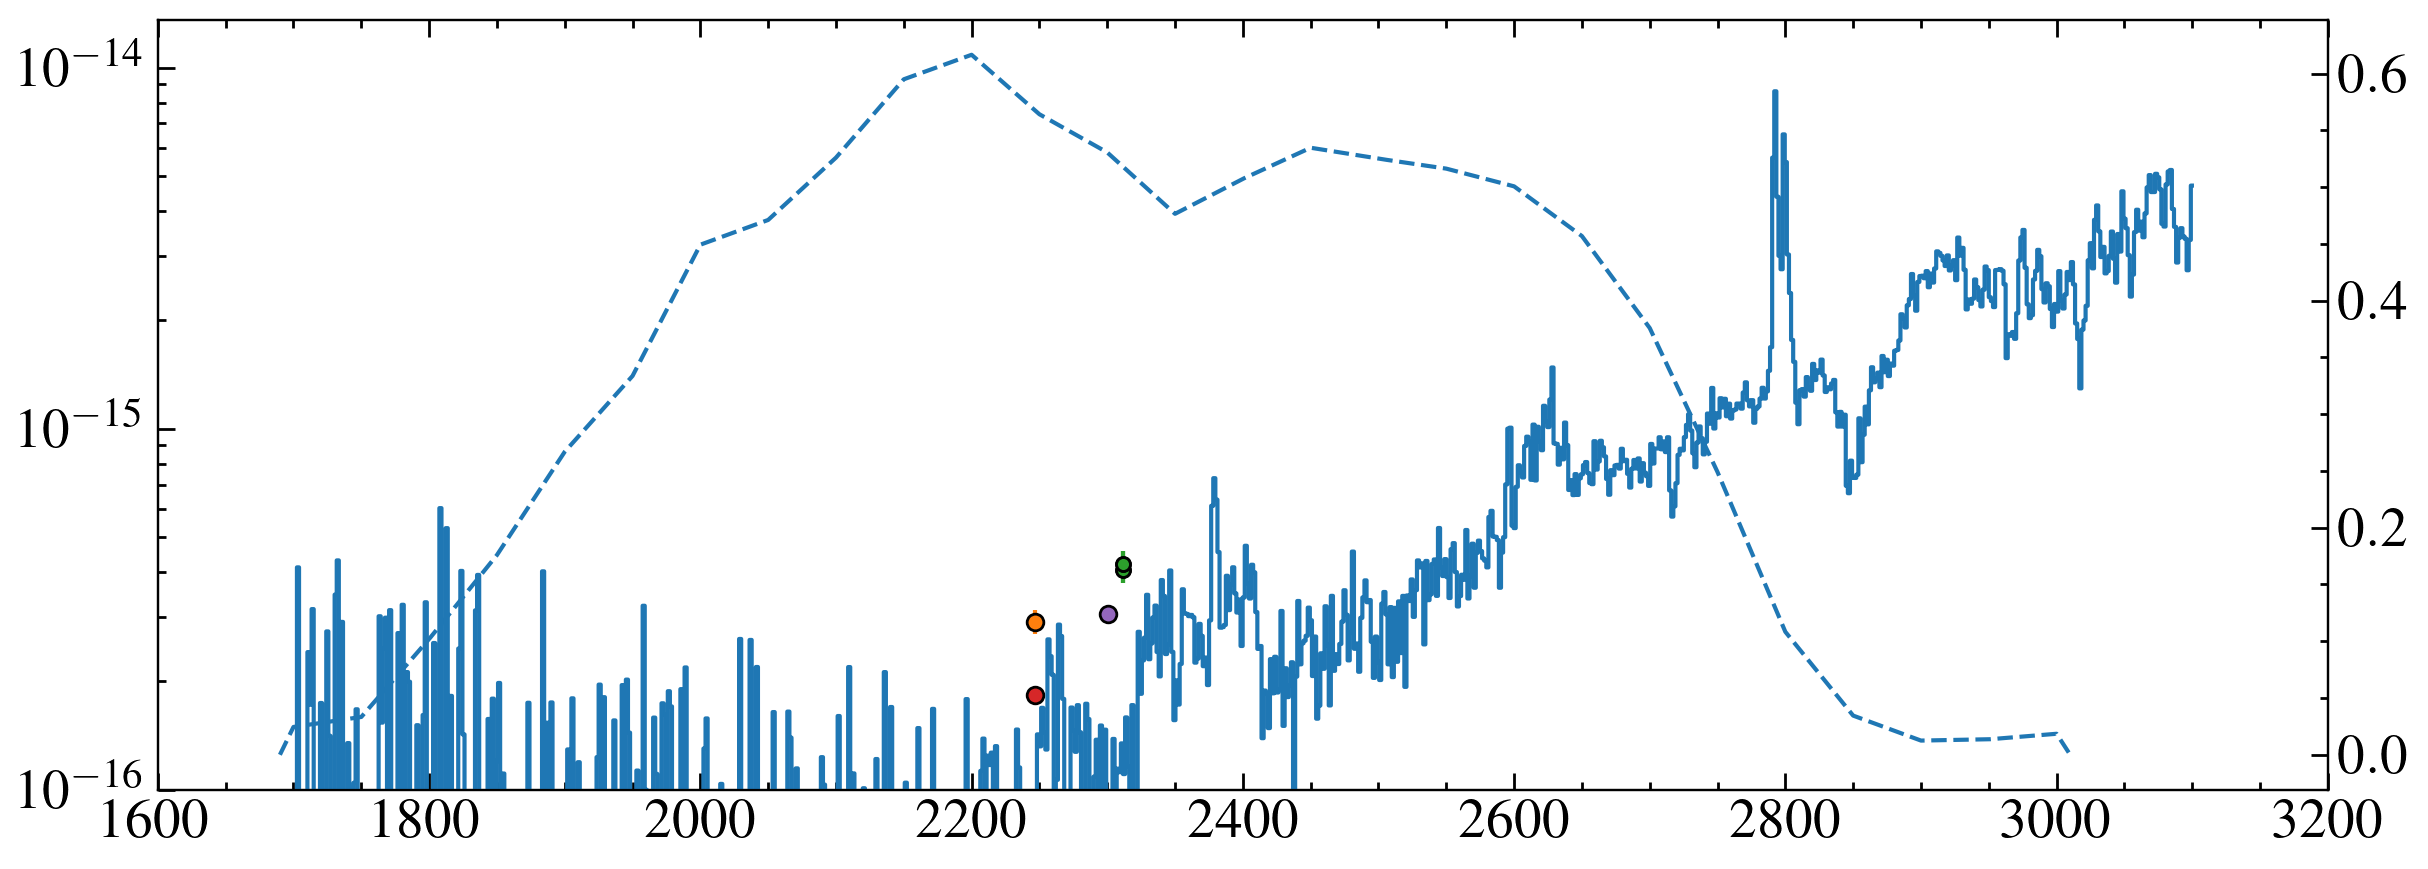

In [12]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 
        
offsets = offtab['Offset(′′)']

pmask = (pw > 2500) & (pw < 10000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


fig, ax = plt.subplots(figsize=(12,5))


ext = F99(Rv=3.1)
ebv = 0.14/3.1
# print(ebv)


# for spec in hlsp_stis:
spec = hlsp_stis[0]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 2950) & (w < 5690 )    
w, f, e = w[mask], f[mask], e[mask]

red = ext.extinguish(w*u.AA, Ebv = ebv)

# ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
ax.step(w, f/red, where='mid', label = 'G430L (E(B-V) = 0.04)', alpha=1, zorder=100)
ax.step(w, (f/red)*1.4, where='mid', label = 'G430L (E(B-V) = 0.04)', alpha=1, zorder=100)

# for off in offsets:
    # dlambda = slit_loss(w, off)
    # ax.step(w, (f/dlambda)/red, where='mid',  alpha=0.5)
    

# spec = hlsp_stis[2]
# data = fits.getdata(spec, 1)
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# mask = (w > 2000) & (w < 3000 )    
# w, f, e = w[mask], f[mask], e[mask]

# red = ext.extinguish(w*u.AA, Ebv = ebv)

# ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
# ax.step(w, f/red, where='mid', label = 'G230L (E(B-V) = 0.04)')

  
ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5, label = 'PHX')

ax.legend(frameon=True)

ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')


gaia = Table.read('misc_data/k2-141_gaia.vot')
mask = gaia['type'] == 'XP'
gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
# mask = (gw > 3000) #& (gw < 1000)
# gw, gf = gw[mask], gf[mask]

gaia_red = ext.extinguish(gw*u.AA, Ebv = ebv)
ax.plot(gw, gf/gaia_red, label='Gaia XP (E(B-V) = 0.04)')

# ax.plot(gw, gf, label='Gaia XP')
phot = Table.read('misc_data/k2-141_phot.vot')



mask = (~phot['sed_eflux'].mask) & (phot['sed_eflux'] > 0) 



phot_w = (phot['sed_freq'][mask]).to(u.AA,  equivalencies=u.spectral())
phot_f = (phot['sed_flux'][mask]).to(u.erg/u.s/u.cm**2/u.AA,  equivalencies=u.spectral_density(phot_w))
phot_e =np.array(phot['sed_eflux'][mask])
phot_e = ((phot_e/phot['sed_flux'][mask]).value)*phot_f.value

mask = phot_f.value/phot_e > 10
# print(phot_e)
# print(phot_e)
# ax.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5)


swift_ws = dict(U=3467.05, UVM2=2246.43, B=4349.56, V=5425.33)

for uvot in uvots:
    data = fits.getdata(uvot, 1)[0]
    band = data['FILTER']
    if band in ['U', 'B', 'V']:
        ax.errorbar(swift_ws[band], data['FLUX_AA'], yerr=data['FLUX_AA_ERR_SYS'], marker='o', markeredgecolor='k', ls='none', c='C6')
        bpw, bpf = np.loadtxt('/home/david/work/filters/uvot/Swift_UVOT.{}.dat'.format(band), unpack=True)
        uflux, uerr = make_phot(bpw, bpf, w, f/red, e/red)
        ax.errorbar(swift_ws[band], uflux, yerr=uerr, marker='o', markeredgecolor='k', ls='none')
        print(band, data['FLUX_AA']/uflux)

#uves useless
# uves_path = '/media/david/2tb_ext_hd/hddata/meats/misc_data/k2-141/'
# uves_specs = glob.glob('{}*ADP*.fits'.format(uves_path))
# for spec in uves_specs:
#     data = fits.getdata(spec, 1)[0]
#     flux = convolve(data['FLUX'], Box1DKernel(500)) 
#     ax.plot(data['WAVE'], flux*1e-15)



ax.set_xlim(3000, 7000)
ax.set_yscale('log')
ax.set_ylim(1e-14)
fig.tight_layout()

fig, ax = plt.subplots()

spec = hlsp_stis[2]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 1700) & (w < 3100 )    
w, f, e = w[mask], f[mask], e[mask]

red = ext.extinguish(w*u.AA, Ebv = ebv)

# ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
ax.step(w, f/red, where='mid', label = 'G230L (E(B-V) = 0.04)',  alpha=1, zorder=100)
# for off in offsets:
#     dlambda = slit_loss(w, off)
#     ax.step(w, (f/dlambda)/red, where='mid',  alpha=0.5)


for uvot in uvots:
    data = fits.getdata(uvot, 1)[0]
    band = data['FILTER']
    if band == 'UVM2':
        ax.errorbar(swift_ws[band], data['FLUX_AA'], yerr=data['FLUX_AA_ERR'], marker='o', markeredgecolor='k', ls='none')
        uvm2flux =  data['FLUX_AA']

mask = (phot_f.value/phot_e > 10) & (phot_w.value < 3000)  
# print(phot_e)
# print(phot_e)
ax.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5, markeredgecolor='k')
nflux = np.mean(phot_f[mask]).value

axr=ax.twinx()

bpw, bpf = np.loadtxt('/home/david/work/filters/uvot/Swift_UVOT.UVM2.dat', unpack=True)
# axr.plot(bpw, bpf, ls='--')
uflux, uerr = make_phot(bpw, bpf, w, f/red, e/red)
ax.errorbar(swift_ws['UVM2'], uflux, yerr=uerr, marker='o', markeredgecolor='k', ls='none')
print('uvm2', uvm2flux/uflux)

bpw, bpf = np.loadtxt('/home/david/work/filters/galex/GALEX_GALEX.NUV.dat', unpack=True)
axr.plot(bpw, bpf, ls='--')

uflux, uerr = make_phot(bpw, bpf, w, f/red, e/red)
ax.errorbar(2300.78, uflux, yerr=uerr, marker='o', markeredgecolor='k', ls='none')
print('gNUV', nflux/uflux)


ax.set_xlim(1600, 3200)
ax.set_yscale('log')
ax.set_ylim(1e-16)




Decision: Scale to the photometry in the NUV, don't use the Optical. Need to deal with the FUV

[92.17609]
958
[130.67415]
957


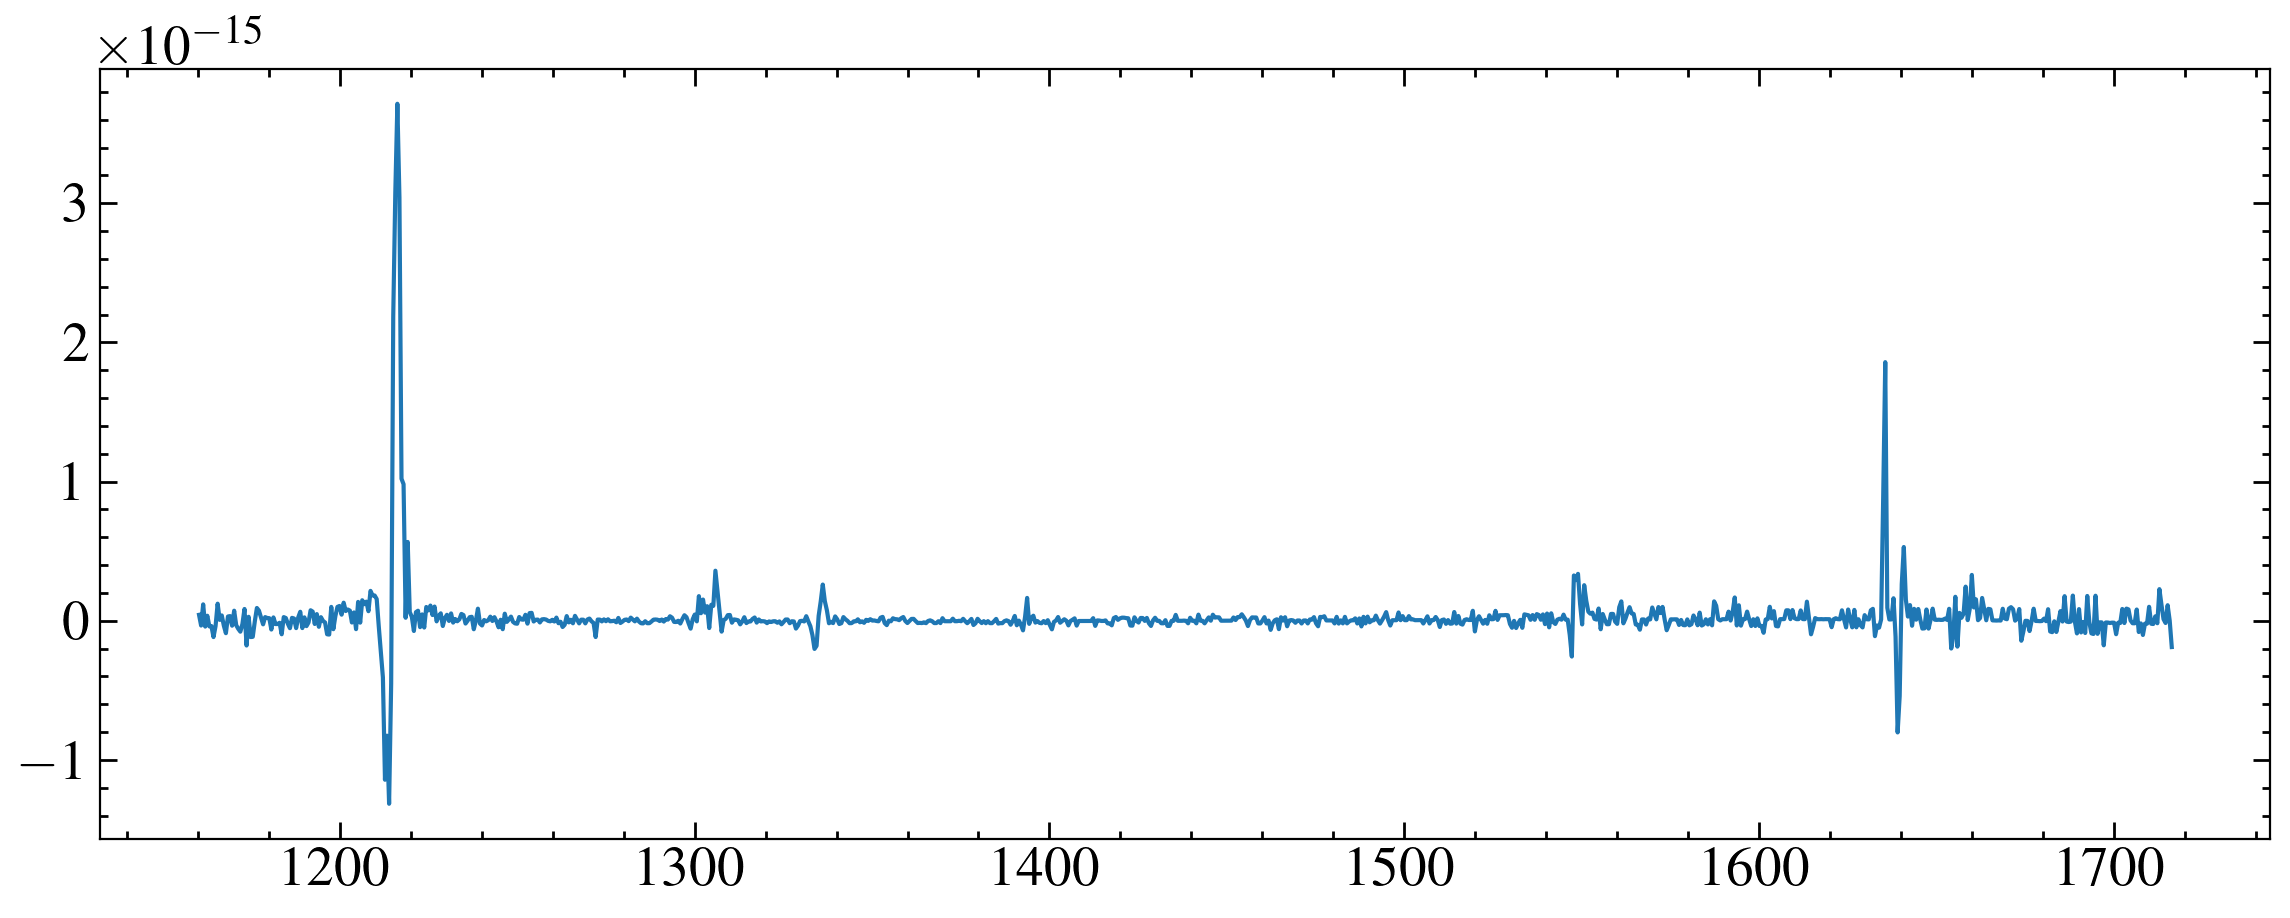

In [13]:
ws = []
fs = []
es = []

for x in x1ds:
    # print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
    # print(fits.getheader(x, 0)['OPT_ELEM'])
        data = fits.getdata(x, 1)
        print(data['A2Center'])
        # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        for dt in data:
            w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
            if grating == 'G430L':
                mask = w > 3000
            else:
                mask = w > 1160
            
            w, f, e = w[mask], f[mask], e[mask]
            # plt.step(w, f, where='mid', alpha=0.7)
            ws.append(w)
            print(len(w))
            fs.append(f)
            es.append(e)
            # plt.step(w, e, where='mid', c='C1')
            # plt.yscale('log')
        # plt.show()
    
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-17)
# plt.ylim(-0.5e-16, 0.5e-15)
diff = np.diff([fs[0][:-1], fs[1]], axis=0)[0]
fig, ax = plt.subplots()


ax.plot(ws[1], diff)